Problem: ViTs produce “artifact” patch tokens that hurt dense tasks (open-vocab seg, depth). Prior “register tokens” help but require retraining from scratch.

Idea (PH-Reg): Add register tokens post-hoc to a student copy of a pretrained ViT and self-distill from a frozen teacher (the original model without registers).

Target creation: Denoise teacher features via simple test-time augs (shifts/flips) and average them to get stable per-patch targets.

Training: Only learn the register embeddings and a tiny subset of layers (e.g., last block/pos-emb/patch-emb); use cosine + MSE losses to match teacher’s denoised dense features.

Why it helps: Registers act as “scratchpads” that soak up nuisance/global artifacts, cleaning attention/feature maps without full finetuning or labels.

Results: Consistent gains on open-vocab and linear-probe segmentation and depth; little change for pure classification. Small inference cost (extra tokens).

Relation: Extends “ViTs Need Registers” to a post-hoc setting; complements “Don’t Need Trained Registers” (a training-free, test-time routing trick) with a one-time lightweight finetune.

## Loading Kaggle Dataset

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("pkdarabi/bone-break-classification-image-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'bone-break-classification-image-dataset' dataset.
Path to dataset files: /kaggle/input/bone-break-classification-image-dataset


In [2]:
import shutil
from pathlib import Path

dest = Path("./data/bone-break")  # your project path
dest.mkdir(parents=True, exist_ok=True)
for item in Path(path).iterdir():
    tgt = dest / item.name
    if item.is_dir():
        shutil.copytree(item, tgt, dirs_exist_ok=True)
    else:
        shutil.copy2(item, tgt)
print("Copied to:", dest)

Copied to: data/bone-break


In [3]:
!pwd

/content


In [4]:
from pathlib import Path
import json

# === Point this to the folder that CONTAINS all class folders ===
CWD = Path.cwd()  # '/content' in Colab
ROOT = CWD / "data" / "bone-break" / "Bone Break Classification" / "Bone Break Classification"

IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".gif"}

def has_images(p: Path) -> bool:
    if not p.exists() or not p.is_dir():
        return False
    for q in p.rglob("*"):
        if q.is_file() and q.suffix.lower() in IMG_EXTS:
            return True
    return False

def derive_class_dirs(root: Path):
    """
    Return a sorted list of (class_name, class_dir) pairs.
    class_dir is the top-level folder representing the class.
    """
    class_pairs = []
    for child in sorted([d for d in root.iterdir() if d.is_dir()], key=lambda x: x.name.lower()):
        # Case 1: images are directly inside the child directory
        if has_images(child):
            class_pairs.append((child.name, child))
            continue

        # Case 2: images live under a Train/train folder inside the child
        train_dir = None
        for name in ("Train", "train"):
            cand = child / name
            if cand.is_dir() and has_images(cand):
                train_dir = cand
                break
        if train_dir is not None:
            class_pairs.append((child.name, child))

    # sanity check
    if not class_pairs:
        raise RuntimeError(f"No class folders with images found under: {root.resolve()}")

    return class_pairs

# ---- Run & summarize ----
class_dirs = derive_class_dirs(ROOT)
class_names = [name for name, _ in class_dirs]
class_to_idx = {name: i for i, name in enumerate(class_names)}

print("Discovered classes:")
for i, name in enumerate(class_names):
    print(f"[{i}] {name}")

# Optional: save mapping for later use
OUT = ROOT / "class_to_idx.json"
with OUT.open("w") as f:
    json.dump(class_to_idx, f, indent=2)
print(f"\nSaved class_to_idx to: {OUT}")

classes = sorted(class_names)

Discovered classes:
[0] Avulsion fracture
[1] Comminuted fracture
[2] Fracture Dislocation
[3] Greenstick fracture
[4] Hairline Fracture
[5] Impacted fracture
[6] Longitudinal fracture
[7] Oblique fracture
[8] Pathological fracture
[9] Spiral Fracture

Saved class_to_idx to: /content/data/bone-break/Bone Break Classification/Bone Break Classification/class_to_idx.json


## Package Setup

In [5]:

# !pip install -U torch torchvision timm tqdm
# !pip install -q kagglehub scikit-learn

import os, math, random, time, glob, json
from dataclasses import dataclass
from typing import Tuple, Optional, List
from pathlib import Path
import kagglehub
import pandas as pd
from sklearn.model_selection import train_test_split

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import timm
from tqdm.auto import tqdm
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


## Configurations

In [68]:
@dataclass
class Config:
    backbone_name: str = "vit_base_patch16_224"
    pretrained: bool = True
    img_size: int = 224
    num_classes: int = 10   # for CIFAR-10
    K_registers: int = 4

    # Finetuning
    unfreeze_last_block_ln: bool = True
    unfreeze_pos_embed: bool = False

    use_kd: bool = False
    kd_T: float = 1.5
    kd_lambda: float = 0.5

    use_feat_consistency: bool = False
    feat_lambda: float = 0.1

    # Optim
    epochs: int = 100
    batch_size: int = 32
    lr: float = 5e-4
    weight_decay: float = 0.05

    # Data
    dataset: str = "bone-break-classification-image-dataset"  # or "CIFAR100"
    data_root: str = "./data"
    num_workers: int = 0
    aug_strength: str = "randaug"  # "light" or "randaug"

cfg = Config()
print(cfg)

Config(backbone_name='vit_base_patch16_224', pretrained=True, img_size=224, num_classes=10, K_registers=4, unfreeze_last_block_ln=True, unfreeze_pos_embed=False, use_kd=False, kd_T=1.5, kd_lambda=0.5, use_feat_consistency=False, feat_lambda=0.1, epochs=100, batch_size=32, lr=0.0005, weight_decay=0.05, dataset='bone-break-classification-image-dataset', data_root='./data', num_workers=0, aug_strength='randaug')


## Data Setup

In [51]:
def build_transforms(img_size: int, aug_strength: str="light"):
    if aug_strength == "randaug":
        train_tfms = transforms.Compose([
            transforms.RandomResizedCrop(img_size, scale=(0.6, 1.0)),
            transforms.RandAugment(num_ops=2, magnitude=7),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225)),
        ])
    else:
        train_tfms = transforms.Compose([
            transforms.Resize(img_size),
            transforms.RandomCrop(img_size, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225)),
        ])
    test_tfms = transforms.Compose([
        transforms.Resize(img_size),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
        transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225)),
    ])
    return train_tfms, test_tfms

In [52]:
from pathlib import Path
from typing import List, Tuple
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from PIL import Image

images_root = Path("./data/bone-break/Bone Break Classification/Bone Break Classification").resolve()
assert images_root.exists(), f"Path not found: {images_root}"

train_tfms, test_tfms = build_transforms(cfg.img_size, cfg.aug_strength)

IMG_EXTS = {".jpg",".jpeg",".png",".bmp",".tif",".tiff"}
class_dirs = [d for d in images_root.iterdir() if d.is_dir()]
# keep dirs that have Train or Test subdirs
class_dirs = [d for d in class_dirs if (d / "Train").exists() or (d / "Test").exists()]
classes = sorted([d.name for d in class_dirs])
class_to_idx = {c: i for i, c in enumerate(classes)}
print("Detected classes:", classes)

def gather_paths(split_name: str) -> List[Tuple[Path, int]]:
    out = []
    for cdir in class_dirs:
        cid = class_to_idx[cdir.name]
        sdir = cdir / split_name  # "Train" or "Test"
        if not sdir.exists():
            continue
        for p in sdir.rglob("*"):
            if p.suffix.lower() in IMG_EXTS and p.is_file():
                out.append((p, cid))
    return out

train_items = gather_paths("Train")
test_items  = gather_paths("Test")
print(f"Found Train images: {len(train_items)} | Test images: {len(test_items)}")

# --- Build stratified Train/Val from TRAIN ONLY ---
train_df_full = pd.DataFrame({"filepath": [str(p) for p, y in train_items],
                              "label_idx": [y for p, y in train_items]})

train_df, val_df = train_test_split(
    train_df_full, test_size=0.2, random_state=42, stratify=train_df_full["label_idx"]
)

test_df = pd.DataFrame({"filepath": [str(p) for p, y in test_items],
                        "label_idx": [y for p, y in test_items]})

class FlatImageDataset(Dataset):
    def __init__(self, df: pd.DataFrame, tfm):
        self.df = df.reset_index(drop=True)
        self.tfm = tfm
    def __len__(self):
        return len(self.df)
    def __getitem__(self, i):
        row = self.df.iloc[i]
        img = Image.open(row["filepath"]).convert("RGB")
        if self.tfm:
            img = self.tfm(img)
        y = int(row["label_idx"])
        return img, y

train_set = FlatImageDataset(train_df, train_tfms)
val_set   = FlatImageDataset(val_df,   test_tfms)
test_set  = FlatImageDataset(test_df,  test_tfms)

cfg.num_classes = len(classes)
print(f"Train: {len(train_set)} | Val: {len(val_set)} | Test: {len(test_set)} | num_classes = {cfg.num_classes}")

train_loader = DataLoader(train_set, batch_size=cfg.batch_size, shuffle=True,
                          num_workers=cfg.num_workers, pin_memory=True, drop_last=True)
val_loader   = DataLoader(val_set,   batch_size=cfg.batch_size, shuffle=False,
                          num_workers=cfg.num_workers, pin_memory=True)
test_loader  = DataLoader(test_set,  batch_size=cfg.batch_size, shuffle=False,
                          num_workers=cfg.num_workers, pin_memory=True)

Detected classes: ['Avulsion fracture', 'Comminuted fracture', 'Fracture Dislocation', 'Greenstick fracture', 'Hairline Fracture', 'Impacted fracture', 'Longitudinal fracture', 'Oblique fracture', 'Pathological fracture', 'Spiral Fracture']
Found Train images: 989 | Test images: 140
Train: 791 | Val: 198 | Test: 140 | num_classes = 10


In [53]:
# Ensure no path overlap between splits
train_paths = set(train_df["filepath"])
val_paths   = set(val_df["filepath"])
test_paths  = set(test_df["filepath"])
assert train_paths.isdisjoint(val_paths)
assert train_paths.isdisjoint(test_paths)
assert val_paths.isdisjoint(test_paths)
print("No overlap between train/val/test. ✅")

No overlap between train/val/test. ✅


## Teacher - Frozen ViT

In [54]:
# Frozen teacher without registers
teacher = timm.create_model(cfg.backbone_name, pretrained=cfg.pretrained, num_classes=cfg.num_classes)
teacher.eval().to(device)
for p in teacher.parameters():
    p.requires_grad_(False)
print("Teacher:", cfg.backbone_name)

Teacher: vit_base_patch16_224


## Student - ViT with Register Tokens

In [69]:
class ViTWithRegisters(nn.Module):
    """Wrap a timm ViT to append K learnable 'register' tokens; pool [CLS + registers] for classification."""
    def __init__(self, backbone_name: str, num_classes: int, K: int = 4, pretrained: bool = True):
        super().__init__()
        self.vit = timm.create_model(backbone_name, pretrained=pretrained, num_classes=num_classes)
        self.num_classes = num_classes
        self.K = K

        # --- Get embedding dim robustly ---
        embed_dim = None
        # common on timm ViTs
        if hasattr(self.vit, "pos_embed") and self.vit.pos_embed is not None:
            embed_dim = self.vit.pos_embed.shape[-1]
        if embed_dim is None and hasattr(self.vit, "embed_dim"):
            embed_dim = self.vit.embed_dim
        if embed_dim is None and hasattr(self.vit, "num_features"):
            embed_dim = self.vit.num_features
        if embed_dim is None and hasattr(self.vit, "patch_embed") and hasattr(self.vit.patch_embed, "proj"):
            embed_dim = self.vit.patch_embed.proj.out_channels
        assert embed_dim is not None, "Could not infer ViT embed dim."

        # --- Learnable registers ---
        self.registers = nn.Parameter(torch.randn(1, K, embed_dim) * 0.02)

        # --- Small head over pooled [CLS + regs] ---
        pooled_dim = embed_dim * (1 + K)
        self.head = nn.Sequential(
            nn.LayerNorm(pooled_dim),
            nn.Linear(pooled_dim, pooled_dim // 2),
            nn.GELU(),
            nn.Linear(pooled_dim // 2, num_classes),
        )

        # --- Freeze backbone ---
        for p in self.vit.parameters():
            p.requires_grad_(False)

        # --- Unfreeze last block LNs ---
        if hasattr(self.vit, "blocks") and len(self.vit.blocks) > 0 and cfg.unfreeze_last_block_ln:
            last_blk = self.vit.blocks[-1]
            if hasattr(last_blk, "norm1"):
                for p in last_blk.norm1.parameters():
                    p.requires_grad_(True)
            if hasattr(last_blk, "norm2"):
                for p in last_blk.norm2.parameters():
                    p.requires_grad_(True)

        # --- Unfreeze positional embedding ---
        if cfg.unfreeze_pos_embed and hasattr(self.vit, "pos_embed") and self.vit.pos_embed is not None:
            self.vit.pos_embed.requires_grad_(True)

        # --- Always train registers + head ---
        self.registers.requires_grad_(True)   # <-- fix: don't call .parameters() on a Parameter
        for p in self.head.parameters():
            p.requires_grad_(True)

    def _pos_with_registers(self, x_tokens, reg, vit):
        """
        x_tokens: [B, 1+K+N, D] after concat([CLS, REG, PATCHES]) but before adding pos
        reg:      [B, K, D]
        vit:      underlying timm ViT (has pos_embed and patch_embed)
        Returns position tensor of same shape as x_tokens to add.
        """
        pos = vit.pos_embed  # [1, 1+N0, D] where N0 is original #patches at pretraining size
        if pos is None:
            return torch.zeros_like(x_tokens)

        B, total_tokens, D = x_tokens.shape
        K = reg.shape[1]
        N_cur = total_tokens - 1 - K  # current #patches from input size
        pos_cls = pos[:, :1, :]       # [1,1,D]
        pos_patch = pos[:, 1:, :]     # [1,N0,D]

        # If grid size changed, interpolate patch positions from old grid to new grid
        N0 = pos_patch.shape[1]
        if N0 != N_cur:
            # infer old/new grids (square)
            G0 = int((N0) ** 0.5)
            G1 = int((N_cur) ** 0.5)
            assert G0*G0 == N0 and G1*G1 == N_cur, "Non-square patch grids; adjust interpolation logic."

            pos_patch_2d = pos_patch.reshape(1, G0, G0, D).permute(0, 3, 1, 2)  # [1,D,G0,G0]
            pos_patch_2d = F.interpolate(pos_patch_2d, size=(G1, G1), mode="bicubic", align_corners=False)
            pos_patch_new = pos_patch_2d.permute(0, 2, 3, 1).reshape(1, G1*G1, D)  # [1,N_cur,D]
        else:
            pos_patch_new = pos_patch

        # K register positions: we can leave as zeros (or tiny learnable embeddings if you prefer)
        pos_reg = torch.zeros(1, K, D, device=pos.device, dtype=pos.dtype)

        pos_full = torch.cat([pos_cls, pos_reg, pos_patch_new], dim=1)  # [1, 1+K+N_cur, D]
        # broadcast over batch
        if pos_full.shape[1] != total_tokens:
            raise RuntimeError(f"pos shape mismatch: got {pos_full.shape[1]} tokens, need {total_tokens}")
        return pos_full

    def forward_features_with_tokens(self, x):
        vit = self.vit
        B = x.shape[0]

        # Patchify
        x = vit.patch_embed(x)                 # [B, N, D]
        cls_token = vit.cls_token.expand(B, -1, -1)   # [B,1,D]
        reg = self.registers.expand(B, -1, -1)        # [B,K,D]

        # Concat [CLS, REG, PATCH]
        x = torch.cat((cls_token, reg, x), dim=1)     # [B,1+K+N,D]

        # Add (interpolated) positional embeddings
        pos_full = self._pos_with_registers(x, reg, vit)
        x = x + pos_full

        if hasattr(vit, "pos_drop"):
            x = vit.pos_drop(x)

        for blk in vit.blocks:
            x = blk(x)

        x = vit.norm(x)
        cls_token = x[:, 0]
        reg_tokens = x[:, 1:1+self.K]
        patch_tokens = x[:, 1+self.K:]
        penultimate = vit.pre_logits(cls_token) if hasattr(vit, "pre_logits") else cls_token
        return cls_token, reg_tokens, patch_tokens, penultimate
    # def forward_features_with_tokens(self, x):
    #     """Return (cls_token [B,D], reg_tokens [B,K,D], patch_tokens [B,N,D], penultimate [B,D])."""
    #     vit = self.vit
    #     B = x.shape[0]

    #     # Patch embed
    #     x = vit.patch_embed(x)                        # [B, N, D]
    #     cls_token = vit.cls_token.expand(B, -1, -1)   # [B, 1, D]
    #     reg = self.registers.expand(B, -1, -1)        # [B, K, D]
    #     x = torch.cat((cls_token, reg, x), dim=1)     # [B, 1+K+N, D]

    #     # Positional embeddings: insert zeros for the K registers
    #     if getattr(vit, "pos_embed", None) is not None:
    #         pos = vit.pos_embed
    #         if pos.shape[1] == 1 + vit.patch_embed.num_patches:
    #             cls_pos, patch_pos = pos[:, :1, :], pos[:, 1:, :]
    #             reg_pos = torch.zeros(1, reg.shape[1], pos.shape[2], device=pos.device, dtype=pos.dtype)
    #             pos_new = torch.cat([cls_pos, reg_pos, patch_pos], dim=1)
    #         else:
    #             pos_new = pos
    #         x = x + pos_new

    #     # pos_drop if present
    #     if hasattr(vit, "pos_drop"):
    #         x = vit.pos_drop(x)

    #     # Transformer blocks
    #     for blk in vit.blocks:
    #         x = blk(x)

    #     x = vit.norm(x)                               # [B, 1+K+N, D]
    #     cls_token = x[:, 0]
    #     reg_tokens = x[:, 1:1+self.K]
    #     patch_tokens = x[:, 1+self.K:]

    #     # pre_logits if present (some timm models)
    #     penultimate = vit.pre_logits(cls_token) if hasattr(vit, "pre_logits") else cls_token
    #     return cls_token, reg_tokens, patch_tokens, penultimate

    def forward(self, x):
        cls_t, reg_t, _, _ = self.forward_features_with_tokens(x)
        pooled = torch.cat([cls_t, reg_t.flatten(1)], dim=1)
        logits = self.head(pooled)
        return logits

student = ViTWithRegisters(cfg.backbone_name, cfg.num_classes, cfg.K_registers, cfg.pretrained).to(device)

N = 4
for p in student.vit.parameters():
    p.requires_grad_(False)
for blk in student.vit.blocks[-N:]:
    for p in blk.parameters():
        p.requires_grad_(True)
if hasattr(student.vit, "pos_embed") and student.vit.pos_embed is not None:
    student.vit.pos_embed.requires_grad_(True)

n_trainable = sum(p.numel() for p in student.parameters() if p.requires_grad)
n_total = sum(p.numel() for p in student.parameters())
print(f"Trainable params: {n_trainable:,} / {n_total:,}")

Trainable params: 35,907,466 / 93,211,028


## Losses

In [72]:
def kd_loss(student_logits, teacher_logits, T: float=1.0):
    s = F.log_softmax(student_logits / T, dim=-1)
    t = F.softmax(teacher_logits / T, dim=-1)
    return F.kl_div(s, t, reduction="batchmean") * (T * T)

@torch.no_grad()
def teacher_logits_fn(x):
    teacher.eval()
    return teacher(x.to(device))

def cheap_consistency_features(x, net):
    # Two simple views: flip and small translation (pad+crop)
    def translate(img, px=2):
        img = F.pad(img, (px, px, px, px), mode="reflect")
        return img[:, :, px:-px, px:-px]

    v1 = x
    v2 = torch.flip(x, dims=[3])  # horizontal flip
    v3 = translate(x, px=2)

    cls1, reg1, _, _ = net.forward_features_with_tokens(v1.to(device))
    cls2, reg2, _, _ = net.forward_features_with_tokens(v2.to(device))
    cls3, reg3, _, _ = net.forward_features_with_tokens(v3.to(device))

    f1 = torch.cat([cls1, reg1.flatten(1)], dim=1)
    f2 = torch.cat([cls2, reg2.flatten(1)], dim=1)
    f3 = torch.cat([cls3, reg3.flatten(1)], dim=1)
    return f1, f2, f3

## Optimizer & Helpers

In [73]:
trainable_params = [p for p in student.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(
    [p for p in student.parameters() if p.requires_grad],
    lr=1e-4, weight_decay=0.05
)
scaler = torch.cuda.amp.GradScaler(enabled=(device.type=="cuda"))

def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            pred = logits.argmax(dim=-1)
            correct += (pred == y).sum().item()
            total += y.numel()
    return correct / total


/tmp/ipython-input-1610700872.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type=="cuda"))


## Train

In [74]:
# before training
patience = 5          # epochs with no improvement before stop
min_delta = 1e-4      # required improvement to reset patience
ckpt_path = "best_student.pt"
monitor = "val_acc"   # or "val_loss" if you compute it
mode = "max"          # "max" for accuracy, "min" for loss

import math, copy, torch

def is_better(curr, best, mode, min_delta):
    if best is None:
        return True
    if mode == "max":
        return (curr - best) > min_delta
    else:  # "min"
        return (best - curr) > min_delta

In [75]:
# deps
from torch import amp
from timm.data.mixup import Mixup
from timm.loss import SoftTargetCrossEntropy

# mixup / cutmix + soft targets
mixup_fn = Mixup(
    mixup_alpha=0.2, cutmix_alpha=1.0, label_smoothing=0.1,
    num_classes=cfg.num_classes, mode="batch"  # avoids even-batch constraint
)

# loss that accepts soft targets (from mixup_fn)
criterion = SoftTargetCrossEntropy()

In [76]:
history = {"train_loss": [], "val_acc": []}
best_metric = None
epochs_no_improve = 0
best_state = None

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)
warmup_epochs = 5
cfg.epochs = 50

for epoch in range(1, cfg.epochs+1):
    if epoch <= warmup_epochs:
        for pg in optimizer.param_groups:
            pg["lr"] = 1e-4 * epoch / warmup_epochs
    student.train()
    running = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch:03d}", leave=False)

    for x, y in pbar:
        if mixup_fn is not None and (x.size(0) % 2 == 1):
          x, y = x[:-1], y[:-1]
        x, y = x.to(device), y.to(device)

        # Keep an un-mixed copy if you use feature-consistency
        x_for_consistency = x

        # ---- Mixup/CutMix (produces soft targets) ----
        targets = y
        if mixup_fn is not None:
            x, targets = mixup_fn(x, y)

        # ---- Forward + loss (new AMP API) ----
        with amp.autocast("cuda", enabled=(device.type=="cuda")):
            logits_s = student(x)
            loss = criterion(logits_s, targets)   # soft-target CE

            # (optional) KD still works; teacher logits are compared via kd_loss
            if cfg.use_kd:
                with torch.no_grad(), amp.autocast("cuda", enabled=(device.type=="cuda")):
                    logits_t = teacher_logits_fn(x)
                loss = loss + cfg.kd_lambda * kd_loss(logits_s, logits_t, cfg.kd_T)

            # (optional) feature consistency — compute on the UNMIXED batch
            if cfg.use_feat_consistency:
                # NOTE: pass the original, un-mixed images
                f1, f2, f3 = cheap_consistency_features(x_for_consistency, student)
                c12 = 1 - F.cosine_similarity(f1, f2, dim=-1).mean()
                c23 = 1 - F.cosine_similarity(f2, f3, dim=-1).mean()
                c31 = 1 - F.cosine_similarity(f3, f1, dim=-1).mean()
                loss = loss + cfg.feat_lambda * (c12 + c23 + c31) / 3.0

        optimizer.zero_grad(set_to_none=True)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running += float(loss)
        pbar.set_postfix(loss=f"{running / (pbar.n or 1):.3f}")

    # ----- validation -----
    val_acc = evaluate(student, val_loader)
    history["train_loss"].append(running / max(1, len(train_loader)))
    history["val_acc"].append(val_acc)
    print(f"Epoch {epoch:03d} | val@top1 = {val_acc*100:.2f}% | loss = {history['train_loss'][-1]:.3f}")

    # ----- early stopping (unchanged) -----
    curr_metric = val_acc if monitor == "val_acc" else val_loss  # if you compute val_loss
    if is_better(curr_metric, best_metric, mode, min_delta):
        best_metric = curr_metric
        epochs_no_improve = 0
        best_state = copy.deepcopy(student.state_dict())
      # save best if you like
        torch.save({"model": best_state, "metric": best_metric, "epoch": epoch}, ckpt_path)
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch}. Best {monitor} = {best_metric:.4f}")
            break

print("Training done.")

# ----- restore best weights -----
if best_state is not None:
    student.load_state_dict(best_state)
    print(f"Loaded best checkpoint from memory (metric={best_metric:.4f}).")

Epoch 001:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 001 | val@top1 = 16.16% | loss = 2.294


Epoch 002:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 002 | val@top1 = 29.29% | loss = 2.230


Epoch 003:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 003 | val@top1 = 28.79% | loss = 2.077


Epoch 004:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 004 | val@top1 = 34.34% | loss = 1.899


Epoch 005:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 005 | val@top1 = 36.87% | loss = 1.904


Epoch 006:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 006 | val@top1 = 41.41% | loss = 1.720


Epoch 007:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 007 | val@top1 = 43.94% | loss = 1.760


Epoch 008:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 008 | val@top1 = 42.42% | loss = 1.652


Epoch 009:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 009 | val@top1 = 45.45% | loss = 1.321


Epoch 010:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 010 | val@top1 = 50.51% | loss = 1.384


Epoch 011:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 011 | val@top1 = 51.01% | loss = 1.475


Epoch 012:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 012 | val@top1 = 48.48% | loss = 1.356


Epoch 013:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 013 | val@top1 = 51.01% | loss = 1.296


Epoch 014:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 014 | val@top1 = 54.04% | loss = 1.387


Epoch 015:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 015 | val@top1 = 54.55% | loss = 1.411


Epoch 016:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 016 | val@top1 = 51.52% | loss = 1.287


Epoch 017:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 017 | val@top1 = 55.56% | loss = 1.427


Epoch 018:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 018 | val@top1 = 52.53% | loss = 1.335


Epoch 019:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 019 | val@top1 = 49.49% | loss = 1.227


Epoch 020:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 020 | val@top1 = 50.00% | loss = 1.266


Epoch 021:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 021 | val@top1 = 54.04% | loss = 1.178


Epoch 022:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 022 | val@top1 = 53.03% | loss = 1.119
Early stopping at epoch 22. Best val_acc = 0.5556
Training done.
Loaded best checkpoint from memory (metric=0.5556).


In [81]:
# --- Load best from Phase 1 ---
ckpt = torch.load("best_student.pt", map_location=device)
student.load_state_dict(ckpt["model"])
print(f"Resumed from phase-1 best (val_acc={ckpt.get('val_acc', -1):.4f}).")

# --- Switch to 384 ---
cfg.img_size = 384
train_tfms, test_tfms = build_transforms(cfg.img_size, cfg.aug_strength)
# rebuild train_loader/val_loader with new transforms
# IMPORTANT: keep the same train/val path lists; only transforms change

# --- Lower LR and reset scheduler ---
for pg in optimizer.param_groups:
    pg["lr"] = max(pg["lr"] * 0.25, 2.5e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15)
warmup_epochs = 0     # usually skip warmup in phase-2
phase2_epochs = 15

# (Optional) lighten Mixup late phase
mixup_fn.mixup_alpha = 0.1
mixup_fn.cutmix_alpha = 0.5

best_metric_p2 = ckpt.get("val_acc", -1)
for epoch in range(1, phase2_epochs+1):
    if epoch <= warmup_epochs:
        for pg in optimizer.param_groups:
            pg["lr"] = 1e-4 * epoch / warmup_epochs
    student.train()
    running = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch:03d}", leave=False)

    for x, y in pbar:
        if mixup_fn is not None and (x.size(0) % 2 == 1):
          x, y = x[:-1], y[:-1]
        x, y = x.to(device), y.to(device)

        # Keep an un-mixed copy if you use feature-consistency
        x_for_consistency = x

        # ---- Mixup/CutMix (produces soft targets) ----
        targets = y
        if mixup_fn is not None:
            x, targets = mixup_fn(x, y)

        # ---- Forward + loss (new AMP API) ----
        with amp.autocast("cuda", enabled=(device.type=="cuda")):
            logits_s = student(x)
            loss = criterion(logits_s, targets)   # soft-target CE

            # (optional) KD still works; teacher logits are compared via kd_loss
            if cfg.use_kd:
                with torch.no_grad(), amp.autocast("cuda", enabled=(device.type=="cuda")):
                    logits_t = teacher_logits_fn(x)
                loss = loss + cfg.kd_lambda * kd_loss(logits_s, logits_t, cfg.kd_T)

            # (optional) feature consistency — compute on the UNMIXED batch
            if cfg.use_feat_consistency:
                # NOTE: pass the original, un-mixed images
                f1, f2, f3 = cheap_consistency_features(x_for_consistency, student)
                c12 = 1 - F.cosine_similarity(f1, f2, dim=-1).mean()
                c23 = 1 - F.cosine_similarity(f2, f3, dim=-1).mean()
                c31 = 1 - F.cosine_similarity(f3, f1, dim=-1).mean()
                loss = loss + cfg.feat_lambda * (c12 + c23 + c31) / 3.0

        optimizer.zero_grad(set_to_none=True)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running += float(loss)
        pbar.set_postfix(loss=f"{running / (pbar.n or 1):.3f}")

    # ----- validation -----
    val_acc = evaluate(student, val_loader)
    history["train_loss"].append(running / max(1, len(train_loader)))
    history["val_acc"].append(val_acc)
    print(f"Epoch {epoch:03d} | val@top1 = {val_acc*100:.2f}% | loss = {history['train_loss'][-1]:.3f}")

    # ----- early stopping (unchanged) -----
    # curr_metric = val_acc if monitor == "val_acc" else val_loss  # if you compute val_loss
    # if is_better(curr_metric, best_metric, mode, min_delta):
    #     best_metric = curr_metric
    #     epochs_no_improve = 0
    #     best_state = copy.deepcopy(student.state_dict())
    #   # save best if you like
    #     torch.save({"model": best_state, "metric": best_metric, "epoch": epoch}, ckpt_path)
    scheduler.step()
    if val_acc > best_metric_p2:
        best_metric_p2 = val_acc
        torch.save({"model": student.state_dict(), "val_acc": best_metric_p2}, "best_phase2.pt")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch}. Best {monitor} = {best_metric:.4f}")
            break
    # early stopping is okay; use a small patience, e.g., 5


Resumed from phase-1 best (val_acc=-1.0000).


Epoch 001:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 001 | val@top1 = 53.54% | loss = 1.157


Epoch 002:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 002 | val@top1 = 53.03% | loss = 1.060
Early stopping at epoch 2. Best val_acc = 0.5556


## Training Curves

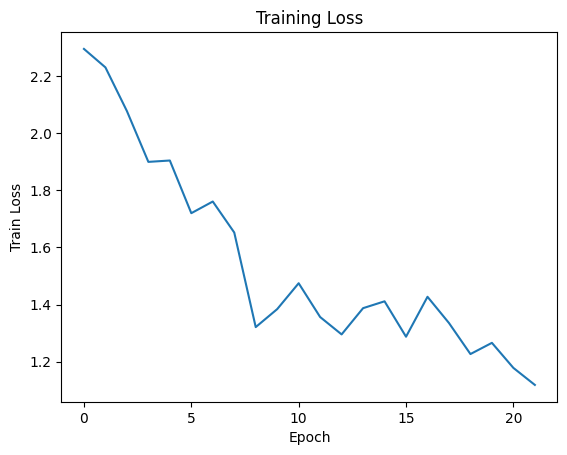

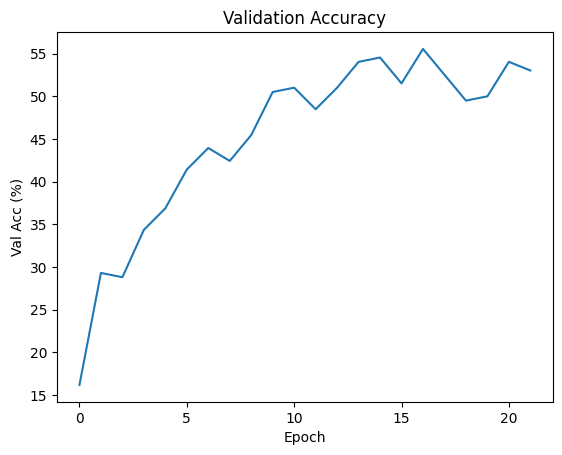

In [78]:

import matplotlib.pyplot as plt

plt.figure()
plt.plot(history["train_loss"])
plt.xlabel("Epoch"); plt.ylabel("Train Loss"); plt.title("Training Loss"); plt.show()

plt.figure()
plt.plot([a*100 for a in history["val_acc"]])
plt.xlabel("Epoch"); plt.ylabel("Val Acc (%)"); plt.title("Validation Accuracy"); plt.show()

## Test

In [79]:
def evaluate_loader(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            pred = logits.argmax(dim=-1)
            correct += (pred == y).sum().item()
            total += y.numel()
    return correct / total

test_acc = evaluate_loader(student, test_loader)
print(f"Test accuracy: {test_acc:.4f}")

Test accuracy: 0.5143


In [82]:
best_ckpt_path = "best_phase2.pt" if Path("best_phase2.pt").exists() else "best_phase1.pt"
ckpt = torch.load(best_ckpt_path, map_location=device)
student.load_state_dict(ckpt["model"])
test_acc = evaluate_loader(student, test_loader)  # your existing helper
print(f"Final Test accuracy: {test_acc:.4f} (from {best_ckpt_path})")

Final Test accuracy: 0.5143 (from best_phase2.pt)
